In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
fake_trj_fname = 'ADP_testset/hallucinated.dcd'
fake_top_fname = 'ADP_testset/AA.pdb'

real_trj_fname = 'ADP_testset/AA.dcd'
real_top_fname = 'ADP_testset/AA.pdb'

In [3]:
def FES_plot(x, y, ax, cbar=False, cax=None, levels=15, nbins=60, weights=None): pyemma.plots.plot_free_energy(x, y, levels=levels, nbins=nbins, ax=ax, cbar=cbar, cax=cax, weights=weights)

# REAL

In [4]:
pdb = real_top_fname
files = real_trj_fname
num_timescales=16
lagtime = 5

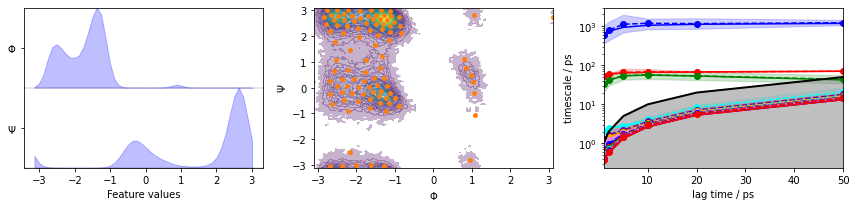

In [5]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

cluster = dt.clustering.KMeans(100, max_iter=500).fit(projected_data).fetch_model()
dtrajs = cluster.transform(projected_data)

#its_result = implied_timescales_msm(dtrajs, lagtimes=[1, 2, 5, 10, 20, 50], nits=num_timescales)
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(projected_data, 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*projected_data.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


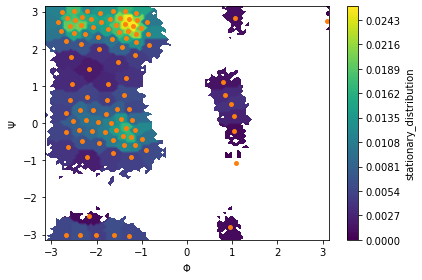

In [6]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *projected_data.T, msm.stationary_distribution[dtrajs],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999947, max=1.0000000000000444)


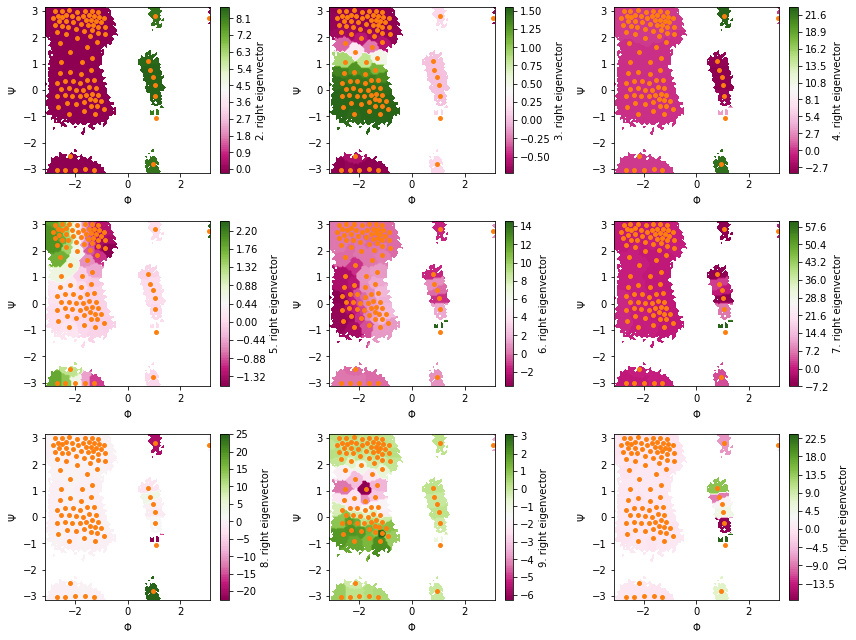

In [7]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *projected_data.T, eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

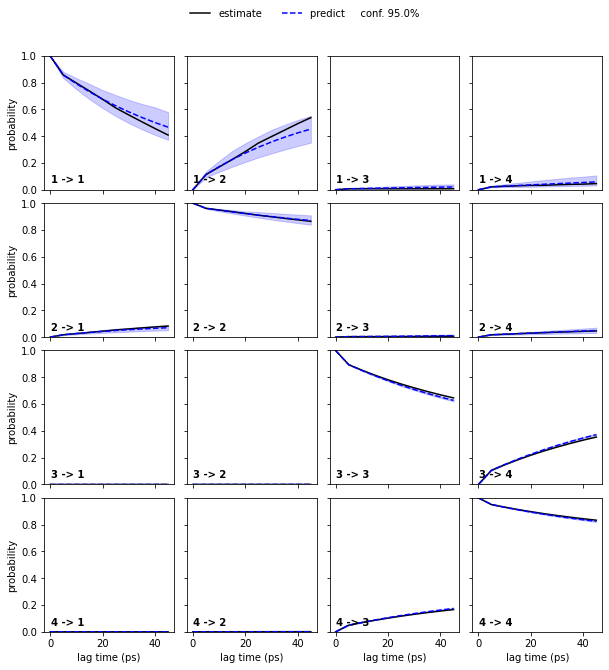

In [8]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [9]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 1018.173600
Confidence interval of ITS #0: [671.701875, 1808.566060]
Mean of ITS #1: 65.442186
Confidence interval of ITS #1: [63.319962, 83.030779]
Mean of ITS #2: 54.339550
Confidence interval of ITS #2: [41.708529, 65.305094]
Mean of ITS #3: 2.828820
Confidence interval of ITS #3: [2.773300, 3.001223]
Mean of ITS #4: 2.221353
Confidence interval of ITS #4: [1.935456, 2.819054]
Mean of ITS #5: 1.986635
Confidence interval of ITS #5: [1.878265, 2.347231]
Mean of ITS #6: 1.855358
Confidence interval of ITS #6: [1.669870, 2.020735]
Mean of ITS #7: 1.723794
Confidence interval of ITS #7: [1.594365, 1.907933]
Mean of ITS #8: 1.645237
Confidence interval of ITS #8: [1.542689, 1.756102]
Mean of ITS #9: 1.580999
Confidence interval of ITS #9: [1.521434, 1.691102]
Mean of ITS #10: 1.540610
Confidence interval of ITS #10: [1.501514, 1.585102]
Mean of ITS #11: 1.521162
Confidence interval of ITS #11: [1.487338, 1.576069]
Mean of ITS #12: 1.503313
Confidence interval of ITS #12: 

In [10]:
evec_real = eigvec
dtrajs_real = dtrajs

In [11]:
real_trj = md.load(files, top=pdb).center_coordinates()

In [12]:
_, phi = md.compute_phi(real_trj, periodic=False)
phi = phi.flatten()
_, psi = md.compute_psi(real_trj, periodic=False)
psi = psi.flatten()

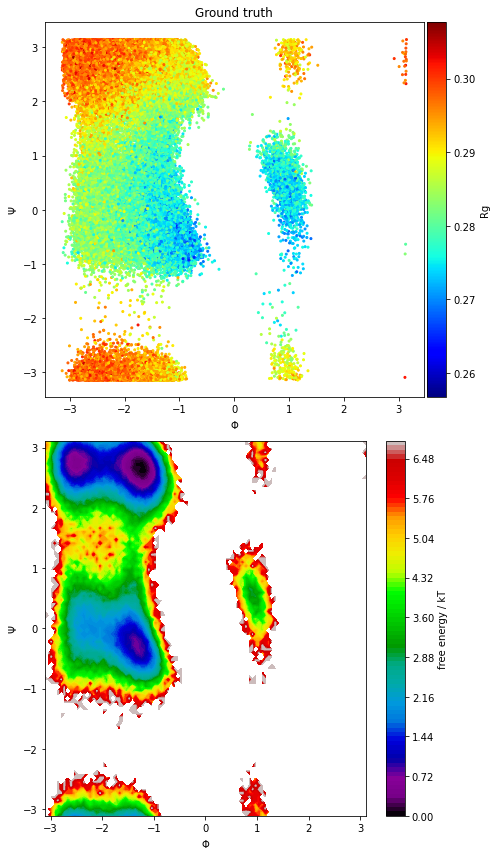

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(7, 12))
s=4
cmap='jet'
im = ax[0].scatter(phi, psi, c=md.compute_rg(real_trj), s=s, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Rg')

ax[0].set_xlabel('$\Phi$')
ax[0].set_ylabel('$\Psi$')
ax[0].set_title('Ground truth')


FES_plot(phi, psi, ax[1], cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax[1].set_xlabel('$\Phi$')
ax[1].set_ylabel('$\Psi$')

plt.tight_layout()
plt.show()

# Fake

In [14]:
pdb = fake_top_fname
files = fake_trj_fname

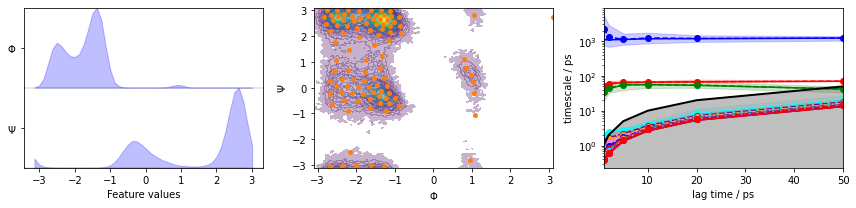

In [15]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

#cluster = dt.clustering.KMeans(100, max_iter=500).fit(projected_data).fetch_model()
dtrajs = cluster.transform(projected_data)

#its_result = implied_timescales_msm(dtrajs, lagtimes=[1, 2, 5, 10, 20, 50], nits=num_timescales)
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(projected_data, 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*projected_data.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


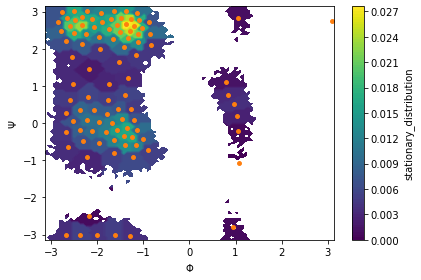

In [16]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *projected_data.T, msm.stationary_distribution[dtrajs],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999997431, max=1.0000000000000058)


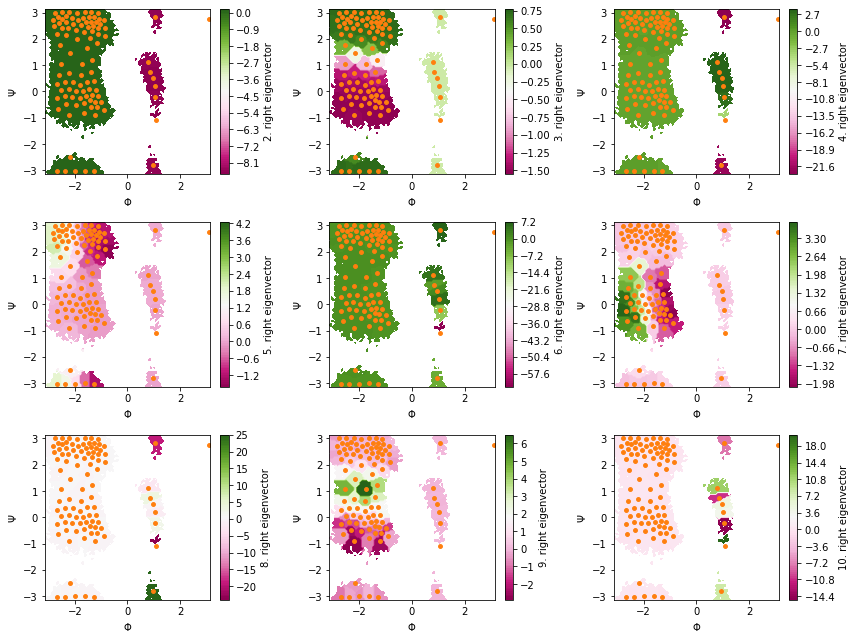

In [17]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *projected_data.T, eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

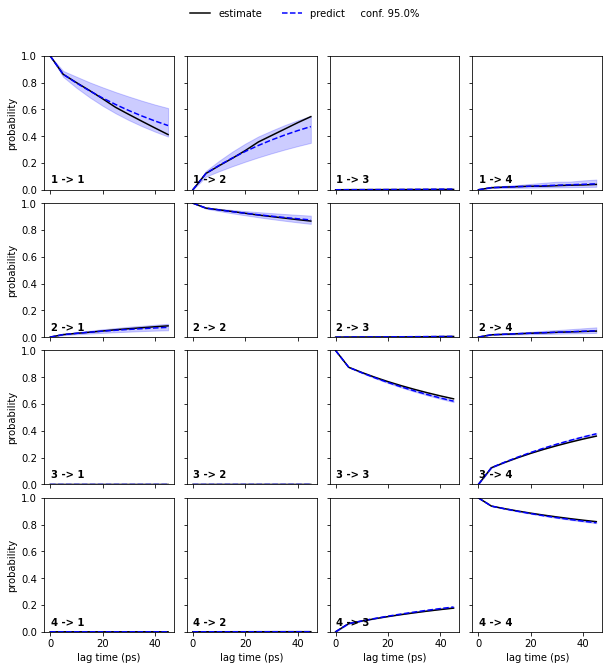

In [18]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [19]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 1089.330286
Confidence interval of ITS #0: [750.922189, 1904.515008]
Mean of ITS #1: 65.776654
Confidence interval of ITS #1: [63.255868, 83.226968]
Mean of ITS #2: 55.354549
Confidence interval of ITS #2: [39.276192, 65.456444]
Mean of ITS #3: 2.834425
Confidence interval of ITS #3: [2.784190, 3.126065]
Mean of ITS #4: 2.235302
Confidence interval of ITS #4: [1.935449, 2.829305]
Mean of ITS #5: 1.991615
Confidence interval of ITS #5: [1.790216, 2.513308]
Mean of ITS #6: 1.854452
Confidence interval of ITS #6: [1.631575, 2.018162]
Mean of ITS #7: 1.723985
Confidence interval of ITS #7: [1.612232, 1.993779]
Mean of ITS #8: 1.643097
Confidence interval of ITS #8: [1.549065, 1.763596]
Mean of ITS #9: 1.584328
Confidence interval of ITS #9: [1.522973, 1.699670]
Mean of ITS #10: 1.542923
Confidence interval of ITS #10: [1.501924, 1.587677]
Mean of ITS #11: 1.521142
Confidence interval of ITS #11: [1.482257, 1.573303]
Mean of ITS #12: 1.503135
Confidence interval of ITS #12: 

In [20]:
evec_fake = eigvec
dtrajs_fake = dtrajs

In [21]:
real_trj = md.load(files, top=pdb).center_coordinates()

In [22]:
_, phi = md.compute_phi(real_trj, periodic=False)
phi = phi.flatten()
_, psi = md.compute_psi(real_trj, periodic=False)
psi = psi.flatten()

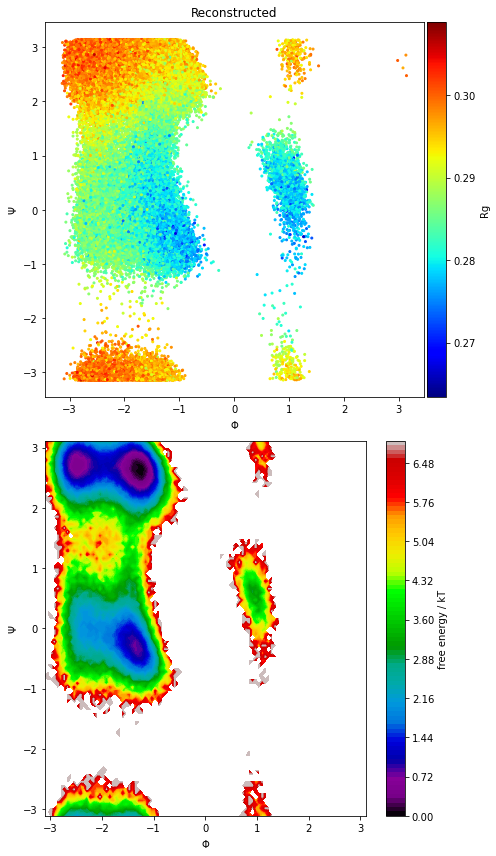

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(7, 12))
s=4
cmap='jet'
im = ax[0].scatter(phi, psi, c=md.compute_rg(real_trj), s=s, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Rg')

ax[0].set_xlabel('$\Phi$')
ax[0].set_ylabel('$\Psi$')
ax[0].set_title('Reconstructed')


FES_plot(phi, psi, ax[1], cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax[1].set_xlabel('$\Phi$')
ax[1].set_ylabel('$\Psi$')

plt.tight_layout()
plt.show()

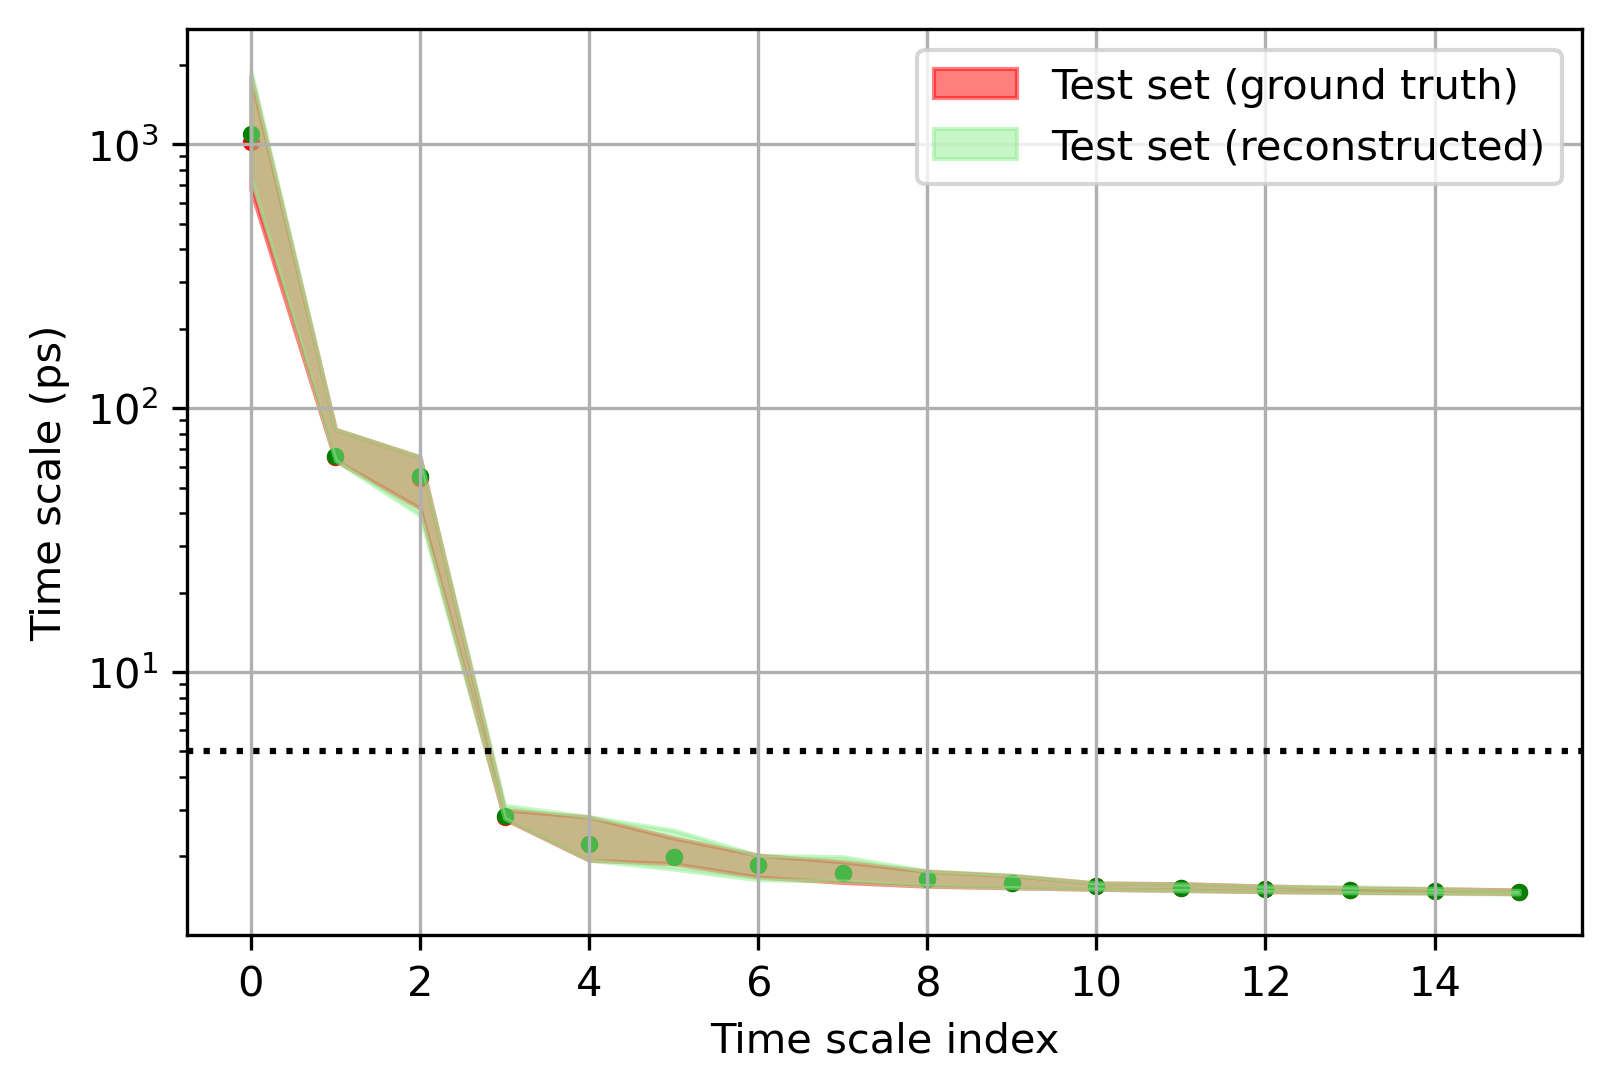

In [24]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Test set (ground truth)')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='Test set (reconstructed)')
plt.yscale('log')

plt.axhline(lagtime, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

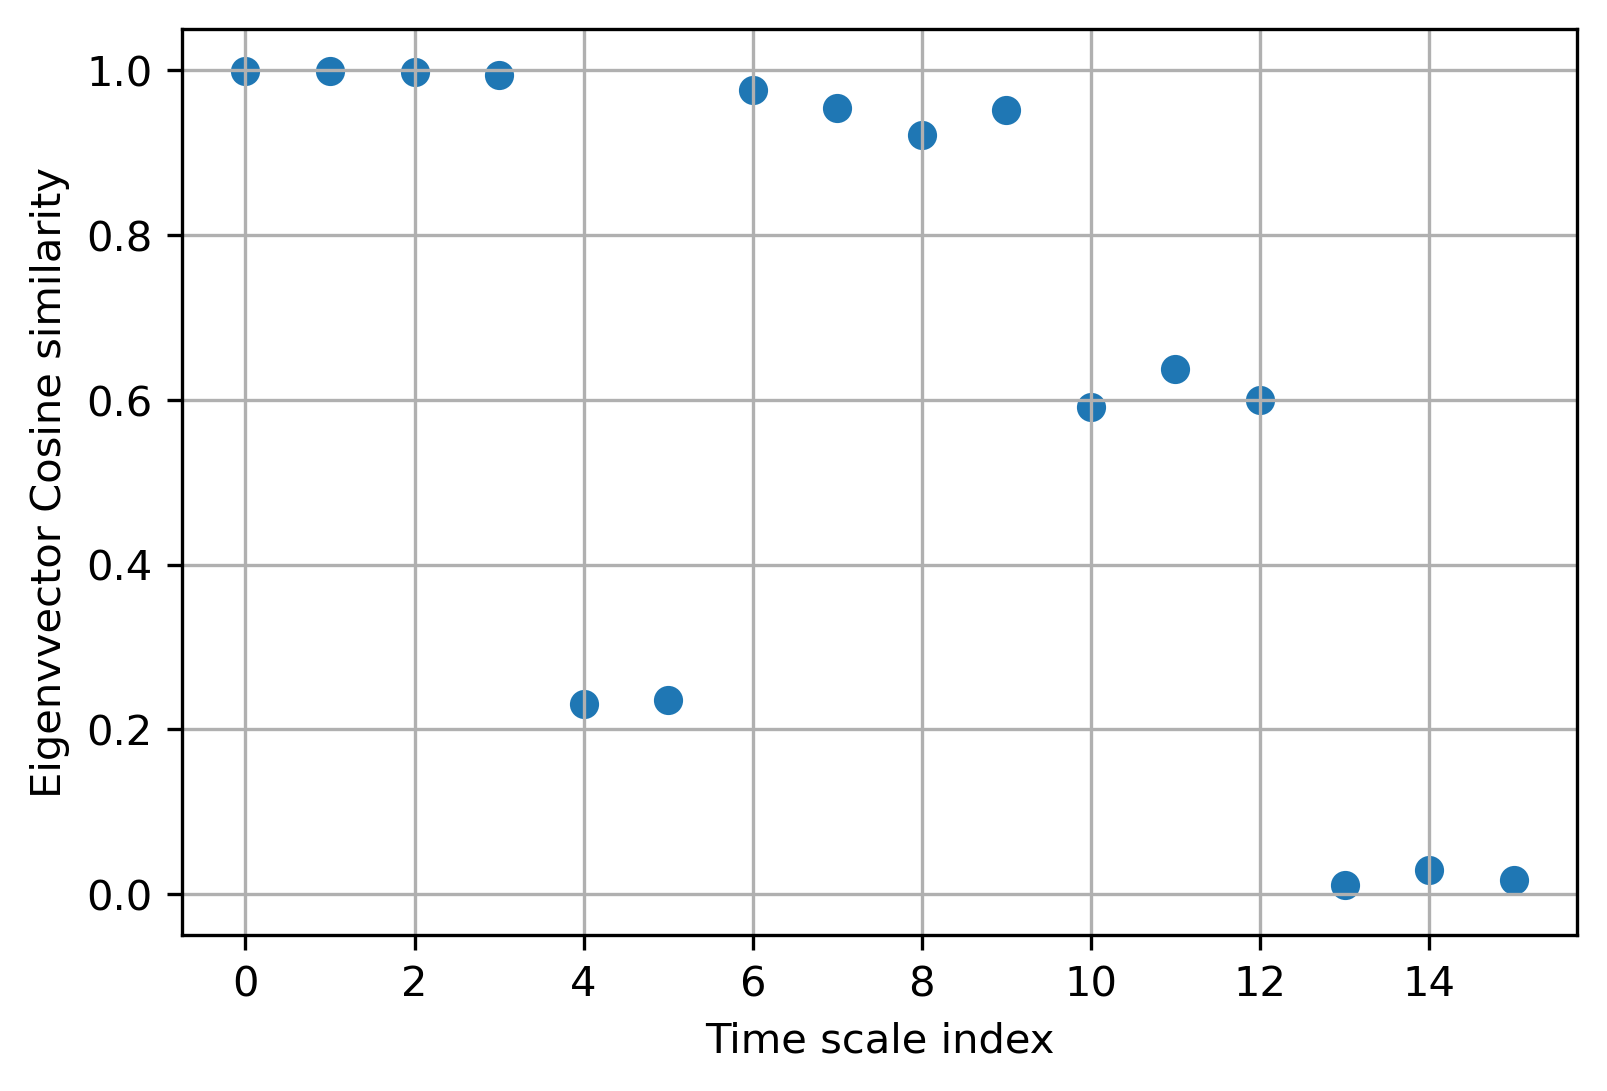

In [25]:
cosine_sims = list()
for i in range(1, num_timescales + 1):
    sim = abs(1 - cosine(evec_fake[dtrajs_fake, i], evec_real[dtrajs_real, i]))
    cosine_sims.append(sim)
plt.figure(dpi=300)
plt.grid()
plt.scatter(range(len(cosine_sims)), cosine_sims) 
plt.xlabel('Time scale index')
plt.ylabel('Eigenvvector Cosine similarity')
plt.ylim(-0.05, 1.05)
plt.show()